In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, wilcoxon

def analyze_and_plot_metrics(markers, language_folders, output_folder='Analysis_Results'):
    """
    Analyzes, plots, and saves F1, Precision, and Recall metrics for given markers across multiple language folders.
    
    Args:
        markers (list): List of marker names to analyze (e.g., ['Accusative', 'Dative', 'Genitive']).
        language_folders (list): List of paths to folders containing language-specific output (e.g., ['Output_comparison_english', 'Output_comparison']).
        output_folder (str): Path to save analysis results.
    
    Returns:
        None
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for language_folder in language_folders:
        language_name = 'English' if 'english' in language_folder.lower() else 'Hungarian'
        
        for marker in markers:
            marker_path = os.path.join(language_folder, marker)
            results_file = os.path.join(marker_path, f'{marker}_results.csv')

            if not os.path.exists(results_file):
                print(f"Results file for {marker} not found in {language_folder}. Skipping...")
                continue

            # Load data
            data = pd.read_csv(results_file)
            layers = data['Layer']
            f1_scores = data['F1-Score']
            precisions = data['Precision']
            recalls = data['Recall']

            # Plotting F1 scores, Precision, and Recall
            plt.figure(figsize=(12, 6))
            plt.plot(layers, f1_scores, label='F1-Score', marker='o')
            plt.plot(layers, precisions, label='Precision', marker='x')
            plt.plot(layers, recalls, label='Recall', marker='s')
            plt.title(f'{marker} Performance Metrics ({language_name})')
            plt.xlabel('Layer')
            plt.ylabel('Score')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plot_file = os.path.join(output_folder, f'{marker}_{language_name}_metrics_plot.png')
            plt.savefig(plot_file)
            plt.close()
            print(f'Saved plot: {plot_file}')

            # Spearman correlation
            with open(os.path.join(output_folder, f'{marker}_{language_name}_correlation_results.txt'), 'w') as file:
                spearman_f1 = spearmanr(layers, f1_scores).correlation
                spearman_precision = spearmanr(layers, precisions).correlation
                spearman_recall = spearmanr(layers, recalls).correlation

                file.write(f'Spearman Correlation Analysis for {marker} ({language_name}):\n')
                file.write(f'F1-Score: {spearman_f1:.4f}\n')
                file.write(f'Precision: {spearman_precision:.4f}\n')
                file.write(f'Recall: {spearman_recall:.4f}\n\n')

                # Wilcoxon test
                file.write('Wilcoxon Signed-Rank Test (relative differences):\n')
                if len(layers) > 1:
                    try:
                        wilcoxon_f1 = wilcoxon(f1_scores.diff().dropna()).pvalue
                        wilcoxon_precision = wilcoxon(precisions.diff().dropna()).pvalue
                        wilcoxon_recall = wilcoxon(recalls.diff().dropna()).pvalue

                        file.write(f'F1-Score p-value: {wilcoxon_f1:.4e}\n')
                        file.write(f'Precision p-value: {wilcoxon_precision:.4e}\n')
                        file.write(f'Recall p-value: {wilcoxon_recall:.4e}\n')
                    except ValueError as e:
                        file.write(f'Wilcoxon test could not be performed: {e}\n')
                else:
                    file.write('Not enough data for Wilcoxon test.\n')

            print(f'Saved analysis: {marker}_{language_name}_correlation_results.txt')


In [3]:
analyze_and_plot_metrics(['Translative', 'Sublative', 'Causal_final'], ['Output_comparison_english', 'Output_comparison'], output_folder='Analysis_Results')


Saved plot: Analysis_Results/Translative_English_metrics_plot.png
Saved analysis: Translative_English_correlation_results.txt
Saved plot: Analysis_Results/Sublative_English_metrics_plot.png
Saved analysis: Sublative_English_correlation_results.txt


/Users/g/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/g/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Saved plot: Analysis_Results/Causal_final_English_metrics_plot.png
Saved analysis: Causal_final_English_correlation_results.txt
Saved plot: Analysis_Results/Translative_Hungarian_metrics_plot.png
Saved analysis: Translative_Hungarian_correlation_results.txt
Saved plot: Analysis_Results/Sublative_Hungarian_metrics_plot.png
Saved analysis: Sublative_Hungarian_correlation_results.txt


/Users/g/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/g/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Saved plot: Analysis_Results/Causal_final_Hungarian_metrics_plot.png
Saved analysis: Causal_final_Hungarian_correlation_results.txt


In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, wilcoxon, friedmanchisquare

def grouped_statistical_analysis(markers, language_folders, output_folder='Grouped_Analysis_Results'):
    """
    Analyzes and compares grouped markers for their performance metrics across layers.
    Plots the F1, Precision, and Recall scores for the groups and calculates statistical similarities.
    
    Args:
        markers (list): List of markers to analyze and compare.
        language_folders (list): List of folder paths for different languages.
        output_folder (str): Directory to save the results and plots.
        
    Returns:
        None
    """
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Store data for grouped analysis
    grouped_data = {lang: {marker: None for marker in markers} for lang in language_folders}

    # Load data from each folder and each marker
    for lang_folder in language_folders:
        lang_name = 'English' if 'english' in lang_folder.lower() else 'Hungarian'

        # Ensure the dictionary for the language exists
        if lang_name not in grouped_data:
            grouped_data[lang_name] = {}
    
    for marker in markers:
        marker_path = os.path.join(lang_folder, marker)
        results_file = os.path.join(marker_path, f'{marker}_results.csv')

        if os.path.exists(results_file):
            # Read CSV and store in grouped data
            grouped_data[lang_name][marker] = pd.read_csv(results_file)
        else:
            print(f"Missing results file for marker: {marker} in {lang_name}")

        
        for marker in markers:
            marker_path = os.path.join(lang_folder, marker)
            results_file = os.path.join(marker_path, f'{marker}_results.csv')

            if os.path.exists(results_file):
                # Read CSV and store in grouped data
                grouped_data[lang_name][marker] = pd.read_csv(results_file)
            else:
                print(f"Missing results file for marker: {marker} in {lang_name}")
    
    # Perform grouped comparison and statistical analysis
    for lang_name, marker_data in grouped_data.items():
        # Prepare to compare markers in the language
        f1_scores, precision_scores, recall_scores = [], [], []
        
        for marker, df in marker_data.items():
            if df is not None:
                # Append data for each metric
                f1_scores.append(df['F1-Score'])
                precision_scores.append(df['Precision'])
                recall_scores.append(df['Recall'])

        if f1_scores:
            # Convert lists to arrays for analysis
            f1_array = np.array(f1_scores)
            precision_array = np.array(precision_scores)
            recall_array = np.array(recall_scores)

            # Plot metrics for grouped markers
            plt.figure(figsize=(12, 6))
            for i, marker in enumerate(markers):
                plt.plot(range(1, 13), f1_array[i], label=f'{marker} (F1)', marker='o')
            plt.title(f'F1 Score Comparison Across Layers ({lang_name})')
            plt.xlabel('Layer')
            plt.ylabel('F1 Score')
            plt.legend()
            plt.savefig(os.path.join(output_folder, f'{lang_name}_F1_Comparison.png'))
            plt.close()

            # Spearman correlation for F1 scores
            spearman_corr, _ = spearmanr(f1_array.T)
            print(f"Spearman Correlation Matrix for F1 Scores ({lang_name}):")
            print(spearman_corr)

            # Wilcoxon signed-rank test for pairwise comparison between markers
            if len(f1_scores) >= 2:
                for i in range(len(markers) - 1):
                    for j in range(i + 1, len(markers)):
                        stat, p_value = wilcoxon(f1_array[i], f1_array[j])
                        print(f"Wilcoxon Test between {markers[i]} and {markers[j]} (F1 Score) p-value: {p_value:.4e}")

            # Friedman test across all groups for F1 scores
            if len(f1_scores) > 2:
                friedman_stat, friedman_p = friedmanchisquare(*f1_scores)
                print(f"Friedman Test for all markers (F1 Score) p-value: {friedman_p:.4e}")

            # Save analysis results to a text file
            with open(os.path.join(output_folder, f'{lang_name}_Group_Analysis.txt'), 'w') as f:
                f.write(f"Spearman Correlation Matrix for F1 Scores ({lang_name}):\n")
                f.write(str(spearman_corr) + '\n\n')
                if len(f1_scores) >= 2:
                    for i in range(len(markers) - 1):
                        for j in range(i + 1, len(markers)):
                            stat, p_value = wilcoxon(f1_array[i], f1_array[j])
                            f.write(f"Wilcoxon Test between {markers[i]} and {markers[j]} (F1 Score) p-value: {p_value:.4e}\n")
                if len(f1_scores) > 2:
                    f.write(f"\nFriedman Test for all markers (F1 Score) p-value: {friedman_p:.4e}\n")

            print(f"Analysis completed for {lang_name}. Results are saved in '{output_folder}'.")


# grouped_statistical_analysis(['Accusative', 'Dative', 'Genitive'], ['Output_comparison_english', 'Output_comparison'], output_folder='Grouped_Analysis_Results')


In [14]:
grouped_statistical_analysis(['Accusative', 'Dative', 'Genitive'], ['Output_comparison_english', 'Output_comparison'], output_folder='Grouped_Analysis_Results')

Spearman Correlation Matrix for F1 Scores (Hungarian):
[[1.         0.08391608 0.40280272]
 [0.08391608 1.         0.15061319]
 [0.40280272 0.15061319 1.        ]]
Wilcoxon Test between Accusative and Dative (F1 Score) p-value: 3.3936e-01
Wilcoxon Test between Accusative and Genitive (F1 Score) p-value: 4.6973e-01
Wilcoxon Test between Dative and Genitive (F1 Score) p-value: 7.9102e-01
Friedman Test for all markers (F1 Score) p-value: 4.7237e-01
Analysis completed for Hungarian. Results are saved in 'Grouped_Analysis_Results'.


In [10]:
grouped_statistical_analysis(['Translative', 'Sublative', 'Causal_final'], [ 'Output_comparison'], output_folder='Grouped_sem_case_Analysis_Results')

Spearman Correlation Matrix for F1 Scores (Hungarian):
[[ 1.          0.17863425 -0.09106844]
 [ 0.17863425  1.         -0.16783217]
 [-0.09106844 -0.16783217  1.        ]]
Wilcoxon Test between Translative and Sublative (F1 Score) p-value: 9.6973e-01
Wilcoxon Test between Translative and Causal_final (F1 Score) p-value: 2.3340e-01
Wilcoxon Test between Sublative and Causal_final (F1 Score) p-value: 3.4180e-02
Friedman Test for all markers (F1 Score) p-value: 4.9787e-02
Analysis completed for Hungarian. Results are saved in 'Grouped_sem_case_Analysis_Results'.


In [12]:
grouped_statistical_analysis(['Plural','VerbConjugation'], [ 'Output_comparison'], output_folder='Grouped_inflect_Analysis_Results')


Spearman Correlation Matrix for F1 Scores (Hungarian):
0.026126315238146257
Wilcoxon Test between Plural and VerbConjugation (F1 Score) p-value: 1.4648e-03
Analysis completed for Hungarian. Results are saved in 'Grouped_inflect_Analysis_Results'.


In [15]:
grouped_statistical_analysis(['Accusative', 'Dative', 'Genitive'], ['Output_comparison_english', 'Output_comparison_english'], output_folder='Grouped_Analysis_english_gramcase_Results')

Spearman Correlation Matrix for F1 Scores (English):
[[ 1.          0.25919479 -0.29370629]
 [ 0.25919479  1.         -0.39229482]
 [-0.29370629 -0.39229482  1.        ]]
Wilcoxon Test between Accusative and Dative (F1 Score) p-value: 5.6934e-01
Wilcoxon Test between Accusative and Genitive (F1 Score) p-value: 9.2773e-03
Wilcoxon Test between Dative and Genitive (F1 Score) p-value: 2.0361e-01
Friedman Test for all markers (F1 Score) p-value: 7.5522e-02
Analysis completed for English. Results are saved in 'Grouped_Analysis_english_gramcase_Results'.


In [16]:
grouped_statistical_analysis(['Translative', 'Sublative', 'Causal_final'], [ 'Output_comparison_english'], output_folder='Grouped_Analysis_english_semcase_Results')


Spearman Correlation Matrix for F1 Scores (English):
[[ 1.         -0.02451843  0.06655001]
 [-0.02451843  1.          0.54385965]
 [ 0.06655001  0.54385965  1.        ]]
Wilcoxon Test between Translative and Sublative (F1 Score) p-value: 5.2246e-02
Wilcoxon Test between Translative and Causal_final (F1 Score) p-value: 5.6934e-01
Wilcoxon Test between Sublative and Causal_final (F1 Score) p-value: 9.2285e-02
Friedman Test for all markers (F1 Score) p-value: 4.5806e-02
Analysis completed for English. Results are saved in 'Grouped_Analysis_english_semcase_Results'.


In [17]:
grouped_statistical_analysis(['Plural','VerbConjugation'], [ 'Output_comparison_english'], output_folder='Grouped_inflect_eng_Analysis_Results')


Spearman Correlation Matrix for F1 Scores (English):
0.12280701754385967
Wilcoxon Test between Plural and VerbConjugation (F1 Score) p-value: 6.2207e-01
Analysis completed for English. Results are saved in 'Grouped_inflect_eng_Analysis_Results'.


In [8]:
import pandas as pd
import os

def calculate_f1_stats(folder_name, internal_folder):
    """
    Calculates the mean and standard deviation of the F1 column in a dataset located
    in a specific folder structure.
    
    Parameters:
    folder_name (str): The name of the main folder.
    internal_folder (str): The name of the internal folder within the main folder.
    
    Returns:
    tuple: Mean and standard deviation of the F1 column.
    """
    # Construct the path to the dataset
    file_path = os.path.join(folder_name, internal_folder, f'{item}_results.csv')
    
    try:
        # Load the dataset
        df = pd.read_csv(file_path)
        
        # Check if the 'F1' column exists
        if 'F1-Score' not in df.columns:
            raise ValueError("The 'F1' column is not present in the dataset.")
        
        # Calculate mean and standard deviation of the F1 column
        f1_mean = df['F1-Score'].mean()
        f1_std = df['F1-Score'].std()
        
        return f1_mean, f1_std
    
    except FileNotFoundError:
        print(f"File not found at path: {file_path}")
        return None
    except ValueError as ve:
        print(ve)
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Example usage:
# mean, std = calculate_f1_stats('Output_comparison', 'internal_folder1')
# print("Mean:", mean, "Standard Deviation:", std)


In [16]:
inflect=['Plural','VerbConjugation']
sem=['Translative', 'Sublative', 'Causal_final']
gram=['Accusative', 'Dative', 'Genitive']
stds=[]
means=[]
markers=['Plural','VerbConjugation','Translative', 'Sublative', 'Causal_final','Accusative', 'Dative', 'Genitive']
for item in inflect:
    
    mean, std = calculate_f1_stats('Output_comparison', item)
    stds.append(std)
    means.append(mean)
    df['marker']=item
    df['std']=std
    df['mean']=mean
    print(item, 'STD:', std, 'Mean:', mean)
    print(item, '\n')


Plural STD: 0.03351980074270854 Mean: 0.7645322314869785
Plural 

VerbConjugation STD: 0.05227573308395813 Mean: 0.6616558111717107
VerbConjugation 



In [17]:
for item in sem:
    
    mean, std = calculate_f1_stats('Output_comparison', item)
    stds.append(std)
    means.append(mean)
    df['marker']=item
    df['std']=std
    df['mean']=mean
    print(item, 'STD:', std, 'Mean:', mean)
    print(item, '\n')

Translative STD: 0.31318087410224943 Mean: 0.4947643542591036
Translative 

Sublative STD: 0.09315168701179576 Mean: 0.4990707991590835
Sublative 

Causal_final STD: 0.13810343163214434 Mean: 0.6472155799180307
Causal_final 



In [18]:
for item in gram:
    
    mean, std = calculate_f1_stats('Output_comparison', item)
    stds.append(std)
    means.append(mean)
    df['marker']=item
    df['std']=std
    df['mean']=mean
    print(item, 'STD:', std, 'Mean:', mean)
    print(item, '\n')

Accusative STD: 0.06993504601517818 Mean: 0.60161745567068
Accusative 

Dative STD: 0.10972940263135586 Mean: 0.5702389990116018
Dative 

Genitive STD: 0.08067600901441149 Mean: 0.5862799599472164
Genitive 



In [31]:
stats_df = pd.DataFrame({
    'STD': stds,
    'MEAN': means,
    'marker': markers
})

In [22]:
print(len(markers))

8


In [24]:
stats_df['markers']=markers

In [49]:
stats_df

,STD,MEAN,marker
0,0.033520,0.764532,Plural
1,0.052276,0.661656,VerbConjugation
2,0.313181,0.494764,Translative
3,0.093152,0.499071,Sublative
4,0.138103,0.647216,Causal_final
5,0.069935,0.601617,Accusative
6,0.109729,0.570239,Dative
7,0.080676,0.586280,Genitive


In [50]:
import pandas as pd

# Sample DataFrame with individual results for demonstration


# Group definitions
groups = {
    'Semantic': ['Translative', 'Sublative', 'Causal_final'],
    'Grammatical': ['Accusative', 'Genitive', 'Dative'],
    'Universal': ['Plural', 'VerbConjugation']
}

# Calculate mean and standard deviation by group and append to the original dataset
for group_name, markers in groups.items():
    group_df = stats_df[stats_df['marker'].isin(markers)]
    group_mean = group_df['MEAN'].mean()
    group_std = group_df['STD'].mean()
    
    # Create a new row for the group and append it to the original DataFrame
    new_row = pd.DataFrame({
        'marker': [group_name + '_Group'],
        'STD': [group_std],
        'MEAN': [group_mean]
    })
    stats_df = pd.concat([stats_df, new_row], ignore_index=True)

# Print the updated DataFrame
print(stats_df)


         STD      MEAN             marker
0   0.033520  0.764532             Plural
1   0.052276  0.661656    VerbConjugation
2   0.313181  0.494764        Translative
3   0.093152  0.499071          Sublative
4   0.138103  0.647216       Causal_final
5   0.069935  0.601617         Accusative
6   0.109729  0.570239             Dative
7   0.080676  0.586280           Genitive
8   0.181479  0.547017     Semantic_Group
9   0.086780  0.586045  Grammatical_Group
10  0.042898  0.713094    Universal_Group


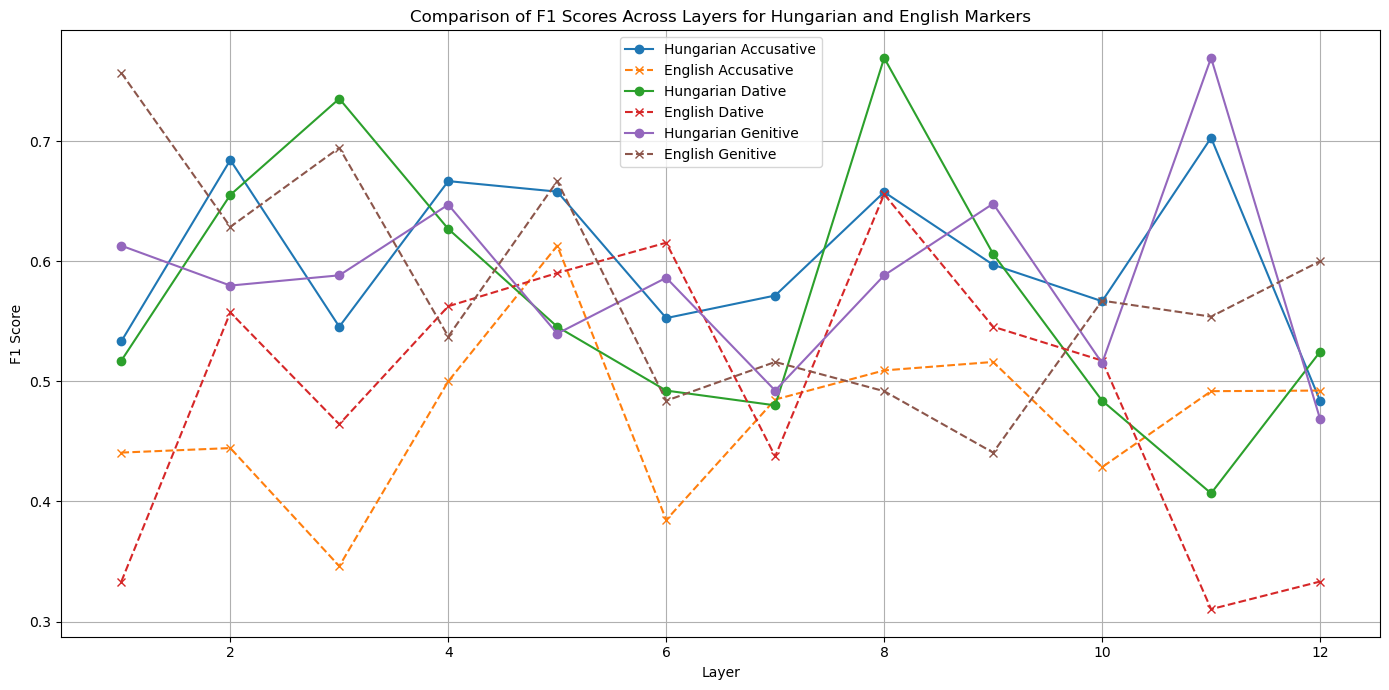

In [47]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_grouped_markers(language_folders, markers, output_folder='Grouped_Marker_Plots'):
    """
    Plots the F1 scores for a group of markers from both languages in one plot.
    Hungarian markers are shown in solid lines, and English markers are in dashed lines.
    
    Args:
        language_folders (dict): Dictionary with keys as language names ('Hungarian', 'English') and values as folder paths.
        markers (list): List of marker names to find and plot in both languages.
        output_folder (str): Directory to save the plot.
        
    Returns:
        None
    """
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Load data for each language and each marker
    data = {lang: {} for lang in language_folders}
    for lang, lang_folder in language_folders.items():
        for marker in markers:
            marker_path = os.path.join(lang_folder, marker)
            results_file = os.path.join(marker_path, f'{marker}_results.csv')

            if os.path.exists(results_file):
                df = pd.read_csv(results_file)
                if 'F1-Score' in df.columns:
                    data[lang][marker] = df['F1-Score'].values
                else:
                    print(f"'F1-Score' column not found in {results_file}")
            else:
                print(f"Results file not found for marker '{marker}' in {lang} at {results_file}")

    # Plot F1 scores for each marker
    plt.figure(figsize=(14, 7))
    layers = range(1, len(next(iter(data['Hungarian'].values()))) + 1)

    for marker in markers:
        if marker in data['Hungarian']:
            plt.plot(layers, data['Hungarian'][marker], label=f'Hungarian {marker}', linestyle='-', marker='o')
        if marker in data['English']:
            plt.plot(layers, data['English'][marker], label=f'English {marker}', linestyle='--', marker='x')

    plt.title('Comparison of F1 Scores Across Layers for Hungarian and English Markers')
    plt.xlabel('Layer')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save the plot
    # output_path = os.path.join(output_folder, 'Marker_Comparison_Plot.png')
    # plt.savefig(output_path)
    plt.show()

    # print(f"Plot saved to {output_path}")

# Example usage
language_folders = {
    'Hungarian': 'Output_comparison',
    'English': 'Output_comparison_english'
}
markers = ['Accusative', 'Dative', 'Genitive']

plot_grouped_markers(language_folders, markers)


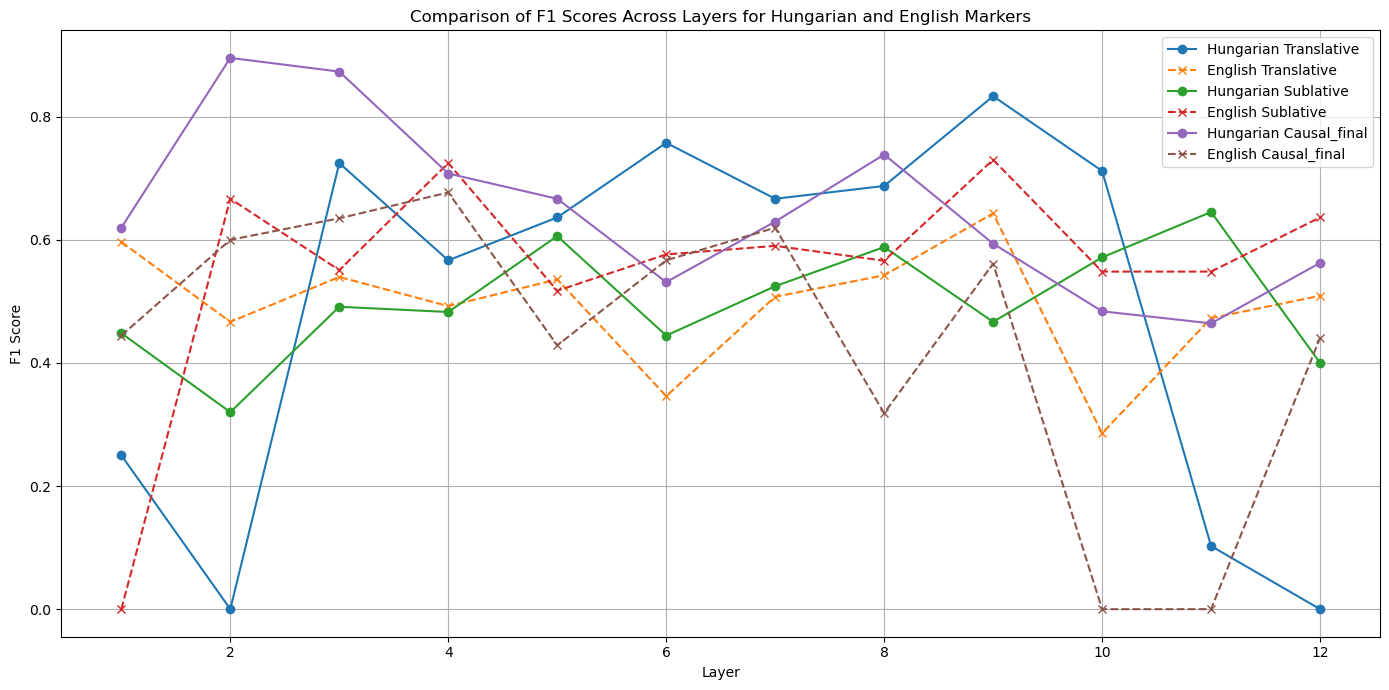

In [48]:
language_folders = {
    'Hungarian': 'Output_comparison',
    'English': 'Output_comparison_english'
}
markers = ['Translative', 'Sublative', 'Causal_final']

plot_grouped_markers(language_folders, markers)